In [1]:
from collections import Counter, defaultdict
from datetime import datetime
from multiprocessing import Pool
import multiprocessing
import math
import os

import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import RandomizedPCA, TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn import metrics
import matplotlib.pyplot as plt


In [2]:
# scale matrix and normalize its rows
def csr_idf(mat, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr #why
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  ## df turns to idf - reusing memory
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else mat

def get_connected_components(core_pts, similarities, metric_type, eps):
    
    core_points_copy = set(core_pts)
    core_clustering = {}
    cluster_id = 1
    while core_points_copy != set([]):
        
        res = 0
        cluster_list = []
        for i in core_points_copy:
            cluster_list.append(i)
            find_connected_node(i, core_pts, similarities, cluster_list, metric_type, eps)
            break
        
        core_clustering[cluster_id] = set(cluster_list)
        core_points_copy -= set(cluster_list)
        cluster_id += 1
#         print(core_points_copy)
    return core_clustering

def find_connected_node(start_node, core_pts, similarities, cluster_list, metric_type, eps):
    temp = []

    for i in similarities[start_node]:
        if metric_type == 'cosine':
            if 1-i[0] > eps: break
        else:
            if i[0] > eps: break
                
        if i[1] not in cluster_list and i[1] in core_pts: #similarities[i[1]][den-1][0] >= eps:
            cluster_list.append(i[1])
            temp.append(i[1])
    for i in temp:        
        find_connected_node(i, core_pts, similarities, cluster_list, metric_type, eps)
        
def add_border_and_noise_pts(pts, similarities, clustering, k=10):
    for i in pts:
        best_score = [0,0]
        score_dict = defaultdict(float)
        count = 0
        for j in range(nrows):
            temp = similarities[i][j][1]
            if clustering[temp] != None: 
#                 score_dict[clustering[temp]] += similarities[i][j][0]
                score_dict[clustering[temp]] += 1
                count += 1
                if count == k: break
        
        for j in score_dict:
            if score_dict[j] > best_score[1]:
                best_score[0] = j
                best_score[1] = score_dict[j]

        clustering[i] = best_score[0]

def g(x):
    res = []
    for i in range(nrows): 
        if i == x: continue
        if type(mat) is np.ndarray:
            sim = mat[x].dot(mat[i])
        else:
            sim = mat[x].dot(mat[i].T).todense().item()
        res.append((sim, i))
    res.sort(reverse=True)

    return res

def g1(x):
    res = []
    for i in range(nrows):
        sim = 0
        if i == x: continue
        for j in range(len(mat[x])):
            sim += (mat[x][j] - mat[i][j])**2
        res.append((math.sqrt(sim), i))
    res.sort()

    return res

def parallel_similarities(metric_type, num_of_processes=2):

#     if dr_flag:
#         dr = TruncatedSVD(n_components=n_components, random_state=1)
#         mat = dr.fit_transform(mat)
#         mat = normalize(mat, axis=1, norm='l2')

    p = Pool(num_of_processes)
    if metric_type == 'cosine':
        similarities = p.map(g, range(nrows))
    else:
        similarities = p.map(g1, range(nrows))
    p.close()
    p.join()
    return similarities

def identify_core_border_noise_pts(eps, den, similarities, metric_type):
    core_pts = []
    border_and_core_pts = []

    for i in range(len(similarities)):
        temp = []
        for j in range(len(similarities[i])):
            if metric_type == 'cosine':
                if 1-similarities[i][j][0] > eps and j >= den:
                    core_pts.append(i)
                    border_and_core_pts += temp
                    break
                elif 1-similarities[i][j][0] > eps and j < den: break
            
            else:
                if similarities[i][j][0] > eps and j >= den:
                    core_pts.append(i)
                    border_and_core_pts += temp
                    break
                elif similarities[i][j][0] > eps and j < den: break
            temp.append(similarities[i][j][1])

        border_and_core_pts += core_pts
    border_pts = set(border_and_core_pts) - set(core_pts)
    noise_pts = set(np.arange(nrows)) - set(border_and_core_pts)
    print('core ', len(core_pts))
    print('border', len(border_pts))
    print('noise ', len(noise_pts))
    return core_pts, border_pts, noise_pts

def graph_k_neighbor(similarities, k, metric_type, y_lim=100):
    x = np.arange(nrows)
    y = []
    for i in range(len(similarities)):
        if metric_type == 'cosine':
            y.append(1 - similarities[i][k][0])
        else:
            y.append(similarities[i][k][0])
    y.sort()
#     dy = np.diff(y)
#     res = []
    
#     batch = 500
#     div = int(len(dy)/batch)
    
#     rem = len(dy) % batch
#     print(div, rem)
#     for i in range(0, div*batch, batch):
#         temp = 0

#         for j in range(batch):
#             temp+= dy[i+j]
#         res.append(temp)

#     print(np.diff(res))
    plt.title('k = ' + str(k))
    plt.xlabel('number of documents')
    plt.ylabel('distance to ' + str(k) + '-th neighbor')
    plt.ylim([0, y_lim])
    plt.plot(x, y, color='r')
    
    xposition = range(0,9000,1000)
    yposition = [i/10 for i in range(10)]

    for i in xposition:
        plt.axvline(x=i, color='c', linestyle='--')
    for i in yposition:
        plt.axhline(y=i, color='c', linestyle='--')

    plt.show()
    return (int(y[7000]*100)-1)/100, int(y[7500]*100)/100, (int(y[8000]*100)+1)/100

In [3]:
with open('train.dat.txt', 'r') as texts:
    raw_texts = texts.readlines()

In [4]:
unique = []
for l in raw_texts:
    temp = l.split()
    for i in range(0, len(temp), 2):
        if int(temp[i]) not in unique: unique.append(int(temp[i]))
unique.sort()

In [5]:
id_map = {}
for i in range(1,len(unique)):
    if unique[i] - unique[i-1] != 1:
        id_map[unique[i]] = unique[i-1] + 1
        unique[i] = unique[i-1] + 1
len(unique)

27673

In [6]:
ptr = [0]
ind = []
val = []
nrows = len(raw_texts)
ncols = 0

for l in raw_texts:
    temp = l.split()
    ptr.append(int(ptr[-1] + len(temp)/2))
    
    doc = []
    for i in range(0, len(temp), 2):
        if int(temp[i]) in id_map:
            doc.append([id_map[int(temp[i])], int(temp[i+1])])
        else:
            doc.append([int(temp[i]), int(temp[i+1])])
    doc.sort()
    for word in doc:
        ind.append(word[0])
        val.append(word[1])
ncols = len(unique) +1


In [7]:
mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
mat = csr_idf(mat, copy=True)
# mat = normalize(mat, axis=1, norm='l2')
# mat = mat.tocsc()
# csr_info(mat)
# print("mat1:", mat[15,:20].todense(), "\n")

In [8]:
dr = TruncatedSVD(n_components=100, random_state=1)
mat = dr.fit_transform(mat)
mat = normalize(mat, axis=1, norm='l2')

In [9]:
def DBSCAN(eps, den, metric_type, k, nrows, y_lim, similarities=None, graph=True):
    
    # get pairwise distance/similarity
    if similarities == None:
        similarities = parallel_similarities(metric_type, multiprocessing.cpu_count())
    
    # draw dkth graph
    if graph:
        eps_and_minpts = []
        for i in range(3,23,2):
            a ,b ,c = graph_k_neighbor(similarities, i, metric_type=metric_type, y_lim = 1)
            eps_and_minpts.append([i,a,b,c])
    
    # identify core/border/noise
    core_pts, border_pts, noise_pts = identify_core_border_noise_pts(eps, den, similarities, metric_type=metric_type)
    
    # find connected components
    core_clustering = get_connected_components(core_pts, similarities, metric_type=metric_type, eps=eps)
    
    # create a list of id-cluster_id
    clustering = [None]*nrows
    for i in core_clustering:
        for j in core_clustering[i]:
            clustering[j] = i
    
    # add border and noise to clusters
    add_border_and_noise_pts(border_pts, similarities, clustering, k)
    add_border_and_noise_pts(noise_pts, similarities, clustering, k)
    
#     for i in core_clustering:
#         print(core_clustering[i])
#     print(clustering)
    
    # modify similarities to get metric
    simm = []
    for i in range(len(similarities)):
        temp = sorted(similarities[i], key=lambda x: x[1])
        if metric_type == 'cosine':
            temp.insert(i, (1.0, i))
            for j in range(len(temp)):
                temp[j] = 1 - temp[j][0]
        else:
            temp.insert(i, (0.0, i))
            for j in range(len(temp)):
                temp[j] = temp[j][0]
        simm.append(temp)
    
    return clustering, simm, similarities


# Best parameters are den = 17 and eps = 0.65

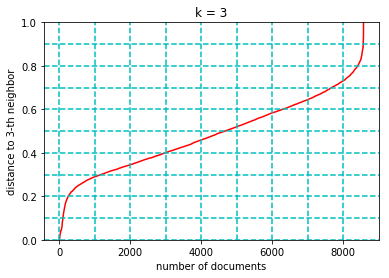

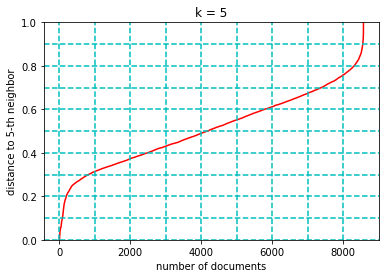

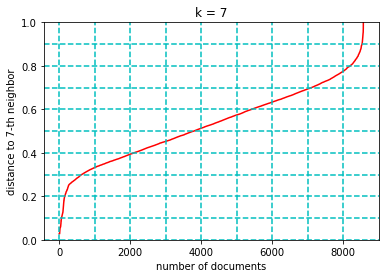

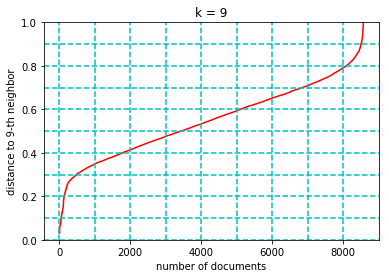

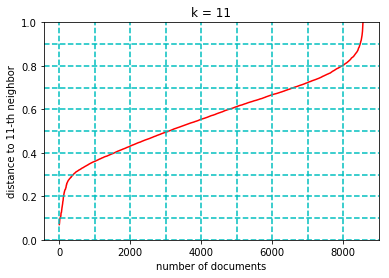

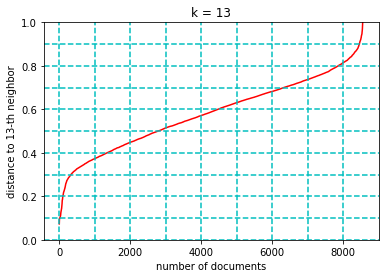

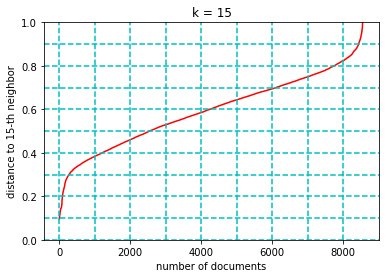

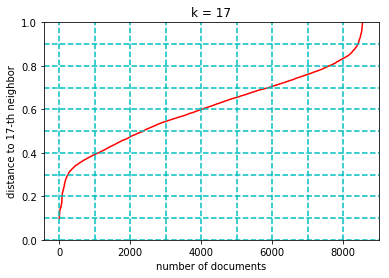

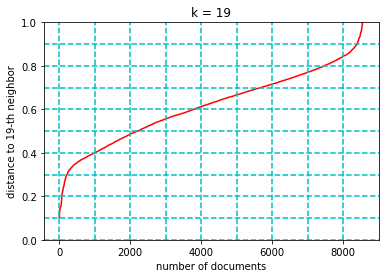

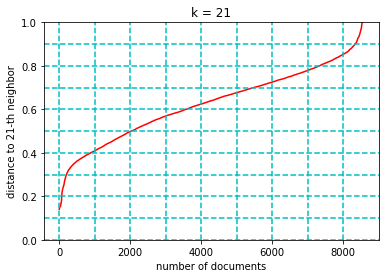

core  4461
border 1872
noise  2247
0.005784476011143525 0.62 17
core  4548
border 1913
noise  2119
-0.016390655973048878 0.625 17
core  4631
border 1921
noise  2028
-0.01985078322256977 0.63 17
core  4733
border 1940
noise  1907
-0.00743731462192971 0.635 17
core  4820
border 1956
noise  1804
0.02022362292347565 0.64 17
core  4910
border 1949
noise  1721
0.027475530254667636 0.645 17
core  5011
border 1921
noise  1648
0.027307887826495167 0.65 17
core  5108
border 1906
noise  1566
-0.004383995156609043 0.655 17
core  5205
border 1921
noise  1454
-0.004961124014402459 0.66 17
core  5313
border 1901
noise  1366
-0.04249534995276594 0.665 17
core  5392
border 1917
noise  1271
-0.08871714705696997 0.67 17
core  5476
border 1921
noise  1183
-0.08856322718105826 0.675 17
core  5567
border 1916
noise  1097
-0.10655313405001232 0.68 17


In [11]:
metric_type = 'euclidean'
eps = [0.62, 0.625, 0.63, 0.635, 0.64, 0.645, 0.65, 0.655, 0.66, 0.665, 0.67, 0.675, 0.68]
den = [17]
# den = [3, 5, 7, 9, 11, 13, 15, 17,19, 21]

res = []

for i in range(len(den)):
    for j in range(len(eps)):
        if i == 0 and j == 0:
            clustering, simm, similarities = DBSCAN(eps=eps[j], den=den[i], metric_type=metric_type, k=10, y_lim=1, nrows=nrows, similarities=None)
        else:
            clustering, simm, similarities = DBSCAN(eps=eps[j], den=den[i], metric_type=metric_type, k=10, y_lim=1, nrows=nrows, similarities=similarities, graph=False)

        score = metrics.silhouette_score(simm, clustering, metric=metric_type)
        res.append([den[i], eps[j], score])
        
        
        with open(str(den[i]) + '_' + str(eps[j]) + '_' + str(score) + '.txt', 'w') as f:
            for c in clustering:
                f.write(str(c))
                f.write('\n')
                
        print(score, eps[j], den[i])
        print('=========================')

In [12]:
print(res)

[[17, 0.62, 0.005784476011143525], [17, 0.625, -0.016390655973048878], [17, 0.63, -0.01985078322256977], [17, 0.635, -0.00743731462192971], [17, 0.64, 0.02022362292347565], [17, 0.645, 0.027475530254667636], [17, 0.65, 0.027307887826495167], [17, 0.655, -0.004383995156609043], [17, 0.66, -0.004961124014402459], [17, 0.665, -0.04249534995276594], [17, 0.67, -0.08871714705696997], [17, 0.675, -0.08856322718105826], [17, 0.68, -0.10655313405001232]]


In [ ]:
# with open('result.txt', 'w') as f:
#     for i in clustering:
#         f.write(str(i))
#         f.write('\n')

[0.005784476011143525, -0.016390655973048878, -0.01985078322256977, -0.00743731462192971, 0.02022362292347565, 0.027475530254667636, 0.027307887826495167, -0.004383995156609043, -0.004961124014402459, -0.04249534995276594, -0.08871714705696997, -0.08856322718105826, -0.10655313405001232]


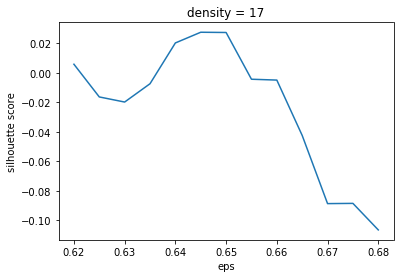

In [13]:
score = [i[2] for i in res]
print(score)
plt.title('density = 17')
plt.xlabel('eps')
plt.ylabel('silhouette score')
#     plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
#     plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
#     plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")


plt.plot(eps, score)

# plt.legend(['density = 3', 'density = 5', 'density = 7', 'density = 9', 'density = 11', 'density = 13'
#            'density = 15', 'density = 17', 'density = 19', 'density = 21'], loc='upper left')
plt.show()

#     plt.ylim([0, y_lim])
#     plt.plot(x, y, color='r')